# IMPORTS #

In [ ]:
pip install supervision

In [9]:
import torch
import pandas as pd
import numpy as np
from ultralytics.utils.ops import xyxy2xywh, xywh2xyxy
from ultralytics.utils.plotting import Annotator, colors
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import shutil
import os
import random
from ultralytics import YOLO
# no longer required
#import fiftyone as fo
#import fiftyone.zoo as foz
import supervision as sv

# Getting the OpenImagesV7 dataset ready for use #

We are going to use the fiftyone lib to get the only the penguin data. \
Then we are going to need to make sure the data is compatible and in the right format for the YOLOv8 model.

## Get only the penguin data from the OpenImagesV7 dataset ##

### Using the fiftyone - this requires the MongaDB so I am going to just work with the dataset directly ###

In [ ]:
# test
# to be removed
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    max_samples=100,
    seed=51,
    shuffle=True,
)

session = fo.launch_app(dataset.view())
# fiftyone is not working working off the bat so I am going to try something else and come back to this


### working with the dataset and annotations directly ###

data is found here: https://storage.googleapis.com/openimages/web/download_v7.html \
\
The goal is to create a list with all the image ids that specify that a penguin has been detected\
The downloader.py function that is supplied by OIV7 (and is saved it the colab directory) can be called and will only download the images in that list\
We then need to check those images and adjust the relevant annotations to only include those ids and save them.\


In [3]:
# path to the parent folder of the raw data

ROOT_RAW_OI7_PATH = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7'

#### Getting the data annotations in a dataframe and filtering to only penguins ####

In [97]:
# load csvs to dataframes to work with
raw_image_labels = pd.read_csv(f'{ROOT_RAW_OI7_PATH}/validation-annotations-human-imagelabels-boxable.csv')
raw_bbox_labels = pd.read_csv(f'{ROOT_RAW_OI7_PATH}/validation-annotations-bbox.csv')

In [43]:
raw_image_labels.head()

,ImageID,Source,LabelName,Confidence
0,0001eeaf4aed83f9,verification,/m/0cmf2,1
1,0004886b7d043cfd,verification,/m/01g317,0
2,0004886b7d043cfd,verification,/m/04hgtk,0
3,0004886b7d043cfd,verification,/m/09j2d,0
4,0004886b7d043cfd,verification,/m/0463sg,0


In [44]:
raw_bbox_labels.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964201,0.071038,0.800546,0,0,0,0,0
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0


the penguin id (found from the oldv7-class-descriptions-boxable.csv file):\
/m/05z6w

In [6]:
# below you can also just make it image labels where LabelName is the same but the confidence score is also equal to 1
# then you dont need to do the removing the rows thing

In [98]:
# create datasets that only contain entries with images in them
penguin_image_labels = raw_image_labels[raw_image_labels['LabelName'] == '/m/05z6w']
penguin_bbox_labels = raw_bbox_labels[raw_bbox_labels['LabelName'] == '/m/05z6w']

In [93]:
penguin_image_labels.head(97)

,ImageID,Source,LabelName,Confidence
6084,01e8e6894bf88777,verification,/m/05z6w,1
7654,025dfa9ea18bcb18,verification,/m/05z6w,0
14090,045f2a7a01277369,verification,/m/05z6w,0
17172,0555911ee31d049f,verification,/m/05z6w,0
24612,07ca230691eec10e,verification,/m/05z6w,1
...,...,...,...,...
482309,9ee32a851eba0eea,verification,/m/05z6w,1
492643,a25a74a471183cee,verification,/m/05z6w,1
495405,a32f24bc0220911f,verification,/m/05z6w,0
516197,a9ddfcc0e100968c,verification,/m/05z6w,1


In [64]:
# get number of rows (number of images)
penguin_image_labels.shape

(1356, 4)

In [95]:
penguin_bbox_labels.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
7934,01e8e6894bf88777,xclick,/m/05z6w,1,0.050186,0.899628,0.014035,0.843860,0,0,0,0,0
30971,07ca230691eec10e,xclick,/m/05z6w,1,0.000000,0.466814,0.625369,1.000000,1,1,0,0,0
30972,07ca230691eec10e,xclick,/m/05z6w,1,0.327434,0.761062,0.122419,0.501475,1,0,0,0,0
30973,07ca230691eec10e,xclick,/m/05z6w,1,0.396018,0.818584,0.215339,0.971976,0,0,0,0,0
37464,099862b891b82c9a,xclick,/m/05z6w,1,0.526549,0.621681,0.309735,0.401180,0,0,0,1,0


In [65]:
# get number of rows (number of bboxs)
penguin_bbox_labels.shape

(4197, 21)

In [66]:
# First I would like to just check that all the ids appear in both lists (sanity check)
# I will remove anything that does not appear in both 
def check_id_presence_in_dfs(df1, df2, id_column, df1_name='df1', df2_name='df2'):
    """
    Check and print IDs that are not present in both dataframes and put them in a list. prints and returns nothing if all ids are present.
    """
    # Set of ids from each df
    ids_df1 = set(df1[id_column])
    ids_df2 = set(df2[id_column])

    # create lists for ids to be removefd
    df1_list_2remove = []
    df2_list_2remove = []

    # Find IDs that are only in df1
    only_in_df1 = ids_df1 - ids_df2
    if only_in_df1:
        #print(f"IDs only in {df1_name}:")
        for id_ in only_in_df1:
            #print(id_)
            df1_list_2remove.append(id_)

    # Find IDs that are only in df2
    only_in_df2 = ids_df2 - ids_df1
    if only_in_df2:
        #print(f"IDs only in {df2_name}:")
        for id_ in only_in_df2:
            #print(id_)
            df2_list_2remove.append(id_)

    return df1_list_2remove, df2_list_2remove

In [99]:
# if returns nothing then all images are present in both dfs
penguin_image_labels_2remove, penguin_bbox_labels_2remove = check_id_presence_in_dfs(penguin_image_labels, penguin_bbox_labels, 'ImageID', 'label', 'bbox')

In [100]:
print(len(penguin_image_labels_2remove))
print(len(penguin_bbox_labels_2remove))

11
0


In [101]:
# function to remove ids that don't appear in both lists
def remove_entries_by_ids(df, id_list, id_column):
    '''Removes rows from the DataFrame where the ID is in the provided list.'''
    filtered_df = df[~df[id_column].isin(id_list)]
    return filtered_df

In [102]:
penguin_image_labels = remove_entries_by_ids(penguin_image_labels, penguin_image_labels_2remove, 'ImageID')
penguin_bbox_labels = remove_entries_by_ids(penguin_bbox_labels, penguin_bbox_labels_2remove, 'ImageID')

In [103]:
penguin_image_labels.shape

(42, 4)

In [104]:
penguin_bbox_labels.shape

(88, 13)

In [105]:
# remove bounding boxes that have 'is group' column = 1
def remove_entries_where_one(df, column_name):
    """
    Removes all entries from the DataFrame where the value in the specified column is 1.
    """
    # Filter the DataFrame to exclude rows where the column value is 1
    filtered_df = df[df[column_name] != 1]
    return filtered_df

In [106]:
penguin_bbox_labels = remove_entries_where_one(penguin_bbox_labels, 'IsGroupOf')

In [107]:
penguin_bbox_labels.shape

(79, 13)

In [108]:
# check that all the same ids appear in both lists
# if returns nothing then all images are present in both dfs
penguin_image_labels_2remove, penguin_bbox_labels_2remove = check_id_presence_in_dfs(penguin_image_labels, penguin_bbox_labels, 'ImageID', 'label', 'bbox')

In [109]:
print(len(penguin_image_labels_2remove))
print(len(penguin_bbox_labels_2remove))

7
0


In [110]:
# remove ids that don't appear in both lists
penguin_image_labels = remove_entries_by_ids(penguin_image_labels, penguin_image_labels_2remove, 'ImageID')
penguin_bbox_labels = remove_entries_by_ids(penguin_bbox_labels, penguin_bbox_labels_2remove, 'ImageID')

In [111]:
penguin_image_labels.shape

(35, 4)

In [112]:
penguin_bbox_labels.shape

(79, 13)

#### creating the text file with a list of all the images the contain penguins and getting all the images from that and downloading those images to a folder - you only need to do this once for the test, train and val datasets on the ####

In [25]:
# create a text file with the following layout:
#$SPLIT/$IMAGE_ID, where $SPLIT is either "train", "test", "validation", or "challenge2018"; and $IMAGE_ID is the image ID that uniquely identifies the image
# so the text file will look like this:
#train/f9e0434389a1d4dd
#train/1a007563ebc18664
#test/ea8bfd4e765304db
# the following function should create the required text file:
def write_ids_to_file(location, name, df):
    """
    Writes entries to a text file where each entry is 'name/id' from the DataFrame's ID column.

    :param location: String, the directory where the text file will be saved.
    :param name: String, the name to be prefixed before each ID.
    :param df: DataFrame, the dataframe containing an 'id' column.
    """
    # Open a file at the specified location to write
    with open(f"{location}/{name}_ids.txt", "w") as file:
        # Loop through each id in the DataFrame
        for id_ in df['ImageID']:
            # Write formatted string to file
            file.write(f"{name}/{id_}\n")

In [113]:
# call the above function for the test images
# call the above function for the test images
# call the above function for the test images
write_ids_to_file(ROOT_RAW_OI7_PATH, 'validation', penguin_image_labels)

Now run the following command in the terminal:\
python3 /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/OpenImagesV7_downloader.py /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/image_list_file.txt --download_folder=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images --num_processes=5

but replace image_list_file.txt with the name of the test file you just created.\
\
The images should be copied to the /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images directory 

In [21]:
# this will allow you to see the row corresponding to the id provided
input_id = '0d6a527e509d7e6e'
matching_row = penguin_image_labels[penguin_image_labels['ImageID'] == input_id]
print(matching_row)

Empty DataFrame
Columns: [ImageID, Source, LabelName, Confidence]
Index: []


In [22]:
# this will allow you to see the row corresponding to the id provided
input_id = '0d6a527e509d7e6e'
matching_row = penguin_bbox_labels[penguin_bbox_labels['ImageID'] == input_id]
print(matching_row)

Empty DataFrame
Columns: [ImageID, Source, LabelName, Confidence, XMin, XMax, YMin, YMax, IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside, XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y]
Index: []

[0 rows x 21 columns]


#### Create the annotation files ####
here we need to create a text file for each image with the following format for each bounding box in that image, where each bounding box is on a new line:\
0 x_centre_value y_centre_value width height \
\
note that all values are normalised between zero and 1

##### convert the bboxs to Yolo format: XCentre YCentre Width Height and save these as new columns to the df and save that dataframe to a .json file 

In [114]:
# first we need to create a function to get bounding boxes in an array in a format:
# x1 y1 x2 y2
# since the origin is in the top left corner, that is to say it must be:
# XMin Ymin XMax YMax
# test
def extract_values_to_array(df, column_names):
    """
    Extracts values from specified columns in a DataFrame and returns them as a numpy array.
    
    :param df: pandas DataFrame from which to extract values.
    :param column_names: List of column names whose values are to be extracted.
    :return: A numpy array with each row corresponding to the values from the specified columns in the DataFrame.
    """ 
    # Extract the values as a numpy array
    array_values = df[column_names].to_numpy()
    
    return array_values


In [115]:
# use the above function to obtain the desired array
list_col_to_extract = ['XMin', 'YMin', 'XMax', 'YMax']

penguin_bbox_labels_arr = extract_values_to_array(penguin_bbox_labels,list_col_to_extract)

print(penguin_bbox_labels_arr[0:10])

[[          0    0.037611      0.9174           1]
 [  0.0088496    0.027982     0.77876           1]
 [    0.12708    0.071875     0.86875      0.9375]
 [    0.31061     0.11532      0.9072      0.9191]
 [     0.1418     0.40618     0.26145     0.84106]
 [      0.226     0.38411     0.34121     0.81457]
 [    0.41654     0.46358     0.54653     0.85872]
 [    0.56573     0.50993     0.70162     0.88079]
 [          0     0.10417     0.19531     0.97292]
 [    0.18594     0.66667     0.27187     0.86458]]


In [116]:
print(penguin_bbox_labels.iloc[1])
# checking the output of the arrayh and it looks good

ImageID        0d2d4e6cefec6f87
Source                   xclick
LabelName              /m/05z6w
Confidence                    1
XMin                    0.00885
XMax                   0.778761
YMin                   0.027982
YMax                        1.0
IsOccluded                    0
IsTruncated                   0
IsGroupOf                     0
IsDepiction                   0
IsInside                      0
Name: 15896, dtype: object


In [117]:
# using the function from Yolo to convert from xyxy to xywh
penguin_bbox_labels_arr_xywh = xyxy2xywh(penguin_bbox_labels_arr)

In [118]:
print(penguin_bbox_labels_arr_xywh[0:10])

[[     0.4587     0.51881      0.9174     0.96239]
 [    0.39381     0.51399     0.76991     0.97202]
 [    0.49792     0.50469     0.74167     0.86562]
 [     0.6089     0.51721     0.59659     0.80379]
 [    0.20162     0.62362     0.11965     0.43488]
 [     0.2836     0.59934     0.11521     0.43046]
 [    0.48154     0.66115     0.12999     0.39514]
 [    0.63368     0.69536     0.13589     0.37086]
 [   0.097656     0.53854     0.19531     0.86875]
 [    0.22891     0.76562    0.085937     0.19792]]


In [119]:
# check the first entry is correct
# check centre x 
print(((penguin_bbox_labels_arr[0, 2] - penguin_bbox_labels_arr[0, 0])/2)+penguin_bbox_labels_arr[0, 0])
# check centre y 
print(((penguin_bbox_labels_arr[0, 3] - penguin_bbox_labels_arr[0, 1])/2)+penguin_bbox_labels_arr[0, 1])
# check centre w 
print((penguin_bbox_labels_arr[0, 2] - penguin_bbox_labels_arr[0, 0]))
# check centre h
print((penguin_bbox_labels_arr[0, 3] - penguin_bbox_labels_arr[0, 1]))

0.45870205
0.51880531
0.9174041
0.96238938


In [120]:
# convert arr to df and specify the column names
new_cols = ['XCentre', 'YCentre', 'Width', 'Height']
penguin_bbox_labels_arr_xywh_df = pd.DataFrame(penguin_bbox_labels_arr_xywh, columns=new_cols, index=penguin_bbox_labels.index)

In [121]:
penguin_bbox_labels_arr_xywh_df.head()

,XCentre,YCentre,Width,Height
3242,0.458702,0.518805,0.917404,0.962389
15896,0.393805,0.513991,0.769912,0.972018
26473,0.497917,0.504687,0.741667,0.865625
35636,0.608902,0.517212,0.596591,0.803787
36350,0.201625,0.623620,0.119645,0.434879


In [122]:
penguin_bbox_labels.shape

(79, 13)

In [123]:
penguin_bbox_labels_arr_xywh_df.shape

(79, 4)

In [124]:
# concat new df to the end of the original df
penguin_bbox_labels_xywh = pd.concat([penguin_bbox_labels, penguin_bbox_labels_arr_xywh_df], axis=1)

In [125]:
penguin_bbox_labels_xywh.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XCentre,YCentre,Width,Height
3242,028d762d6716abdf,xclick,/m/05z6w,1,0.000000,0.917404,0.037611,1.000000,0,1,0,0,0,0.458702,0.518805,0.917404,0.962389
15896,0d2d4e6cefec6f87,xclick,/m/05z6w,1,0.008850,0.778761,0.027982,1.000000,0,0,0,0,0,0.393805,0.513991,0.769912,0.972018
26473,1654d220ef8dfb40,xclick,/m/05z6w,1,0.127083,0.868750,0.071875,0.937500,0,0,0,0,0,0.497917,0.504687,0.741667,0.865625
35636,1e20429aac140db6,xclick,/m/05z6w,1,0.310606,0.907197,0.115318,0.919105,0,0,0,0,0,0.608902,0.517212,0.596591,0.803787
36350,1ed640a7fc509e10,xclick,/m/05z6w,1,0.141802,0.261448,0.406181,0.841060,0,0,0,0,0,0.201625,0.623620,0.119645,0.434879


In [126]:
penguin_bbox_labels_xywh.shape

(79, 17)

In [127]:
# now save it as a .json file so we dont have to do this again
# we will use the orient = 'records' as this is the default and
# the most common
json_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7'
json_path = f'{json_path_parent}/validation_full_annotation_NG.json'

penguin_bbox_labels_xywh.to_json(json_path, orient='records')

##### Run the below to load the full annotations to a df #####

In [22]:
# the following code will read a .json file to a df
# just uncomment and run the code below changing the name of the json file
json_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/validation_full_annotation.json'
df = pd.read_json(json_path, orient='records')


In [23]:
df.shape

(88, 17)

##### step through the df and create a text file for each unique instance of an image id then add: 0 XCentre YCentre Width Height as a new line for each bounding box for a specific image id #####

In [182]:
# create a function 
def df_to_YOLO_txt_file(df, txt_file_path_parent):
    # step through the df
    for index, entry in df.iterrows():
        # get info from entry
        ImageID = entry['ImageID']
        XCentre = entry['XCentre']
        YCentre = entry['YCentre']
        Width = entry['Width']
        Height = entry['Height']

        txt_file_path = f'{txt_file_path_parent}/{ImageID}.txt'

        # write info to text file in desired format
        with open(txt_file_path, 'a') as file:
            file.write(f'0 {XCentre} {YCentre} {Width} {Height}\n')


In [129]:
# before running the below you need to check the number of files
# in the destination folder so you can see that the correct number of 
# txt files have been made (should = number of penguin_image_label)
penguin_image_labels.shape

(35, 4)

In [84]:
txt_file_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
df_to_YOLO_txt_file(penguin_bbox_labels_xywh, txt_file_path_parent)

In [ ]:
# now check the number of files in the folder (just use file explorer)

#### View the results to check they are correct ####

##### attempt to use supervision #####

In [91]:
image = cv.imread('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images/3df173193a2bac8b.jpg')
ann = Annotator(image)
txt_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations/3df173193a2bac8b.txt'
bbox_arr = np.loadtxt(txt_path, dtype=np.float16, delimiter=' ', usecols=(1,2,3,4))
bbox_tensor = torch.from_numpy(bbox_arr)
bbox_dict = {'predictions': tuple(row[:]) for row in bbox_arr}

In [92]:
print(bbox_arr)
print(bbox_tensor)
print(bbox_dict)

[[    0.40332     0.75977    0.051636     0.16589]
 [    0.51172     0.79297    0.097351     0.16589]
 [    0.58545     0.77637    0.061951     0.15491]]
tensor([[0.4033, 0.7598, 0.0516, 0.1659],
        [0.5117, 0.7930, 0.0974, 0.1659],
        [0.5854, 0.7764, 0.0620, 0.1549]], dtype=torch.float16)
{'predictions': (0.5854, 0.7764, 0.06195, 0.1549)}


In [93]:
detect1 = sv.Detections.from_inference(bbox_dict)

KeyError: 'image'

In [82]:
box_annotator = sv.BoundingBoxAnnotator()
annotated_frame = box_annotator.annotate(image.copy(), detections=bbox_tensor)
sv.plot_image(image=annotated_frame, size=(16, 16))

AttributeError: 'Tensor' object has no attribute 'xyxy'

##### Attempt to use cv #####

In [3]:
# display images inline
%matplotlib inline

In [4]:
image_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images/381820d77d917c77.jpg'
txt_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations/381820d77d917c77.txt'
bbox_arr = np.loadtxt(txt_path, dtype=np.float16, delimiter=' ', usecols=(1,2,3,4))

In [5]:
print(bbox_arr)

[    0.50195     0.55469      0.6665     0.89062]


In [14]:
def draw_bboxes_and_show(image_path, bboxes):
    """
    Draws bounding boxes on an image and displays it inline in a Jupyter Notebook.

    :param image_path: Path to the image file.
    :param bboxes: NumPy array of bbox in the format [x_center, y_center, width, height] as normalized values.
    """
    # Load the image
    img = cv2.imread(image_path)
    
    # Ensure the image was loaded
    if img is None:
        print("Image not loaded; please check the path.")
        return
    
    # Ensure bboxes is at least 2D (cam't work with 1d arrays)
    if bboxes.ndim == 1:
        bboxes = bboxes[np.newaxis, :]  # Convert 1D array to a 2D array with one row

    
    # Convert bounding box coordinates from normalized to absolute pixel values
    height, width = img.shape[:2]
    print(height, width)
    scaled_bboxes = np.zeros_like(bboxes) # creating emptry array of correct size
    print(scaled_bboxes.shape)
    print(scaled_bboxes[:, 0])
    scaled_bboxes[:, 0] = (bboxes[:, 0] - (bboxes[:, 2] / 2))* width   # x_min
    scaled_bboxes[:, 1] = (bboxes[:, 1] - bboxes[:, 3] / 2)* height  # y_min
    scaled_bboxes[:, 2] = (bboxes[:, 0] + bboxes[:, 2] / 2)* width   # x_max
    scaled_bboxes[:, 3] = (bboxes[:, 1] + bboxes[:, 3] / 2)* height  # y_max
    
    #print(scaled_bboxes)
    # Draw each bounding box on the image
    for (x_min, y_min, x_max, y_max) in scaled_bboxes:
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
    
    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

1024 768
(1, 4)
[          0]


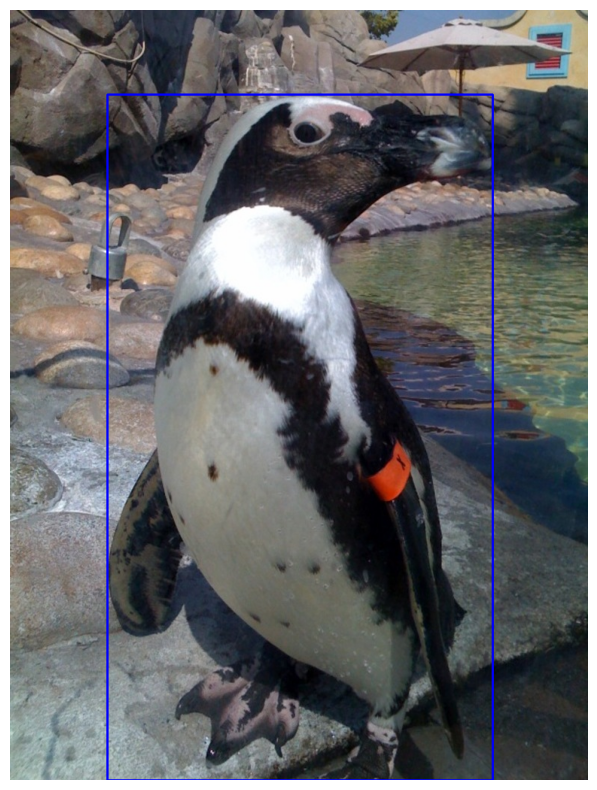

In [15]:
#print(bbox_arr)
draw_bboxes_and_show(image_path, bbox_arr)

## Get the OI7 images in a train, validation and test datasets ##


### original split as per the OI7 dataset###
I am going to use the original train set. I am going to use the original test images for the validation set (there are more images in the test set than validation) and the original validation for the test set\
train = 894 images, 4197 bboxes \
validation = 97 images, 165 bboxes \
test = 42 images, 88 bboxes

In [1]:
# function to copy all the images that ids appear in a file to the desired location (specified for the yolo format)

def copy_images_based_on_ids(text_file_path, source_dir, destination_dir):
    """
    Copies images from source directory to destination directory based on IDs listed in a text file.
    
    :param text_file_path: Path to the text file containing IDs.
    :param source_dir: Directory where images are stored (images should be named as <id>.jpg).
    :param destination_dir: Directory to which images will be copied.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Open the text file and read line by line
    with open(text_file_path, 'r') as file:
        for line in file:
            # Extract the ID from each line (assuming format 'some_text/<id>')
            line = line.strip()
            id_ = line.split('/')[-1]  # Splits the line at '/' and takes the last part as the ID

            # Construct the filename and the paths
            filename = f"{id_}.jpg"
            source_path = os.path.join(source_dir, filename)
            destination_path = os.path.join(destination_dir, filename)

            # Check if the file exists and copy it to the destination directory
            if os.path.exists(source_path):
                shutil.copy(source_path, destination_path)
                print(f"Copied {filename} to {destination_dir}")
            else:
                print(f"File {filename} not found in {source_dir}")

In [6]:
# copy images for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest images and will be used for my test set
text_file_path_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/validation_ids.txt'
image_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
Yolo_image_folder_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/test'

copy_images_based_on_ids(text_file_path_test, image_source, Yolo_image_folder_test)

Copied 028d762d6716abdf.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/test
Copied 0d2d4e6cefec6f87.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/test
Copied 1654d220ef8dfb40.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/test
Copied 1d9ddcae0b59b04c.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/test
Copied 1e20429aac140db6.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/test
Copied 1ed640a7fc509e10.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/imag

In [8]:
# copy images for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest images and will be used for my test set
text_file_path_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_ids.txt'
image_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
Yolo_image_folder_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/val'

copy_images_based_on_ids(text_file_path_val, image_source, Yolo_image_folder_val)

Copied 01e8e6894bf88777.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/val
Copied 07ca230691eec10e.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/val
Copied 099862b891b82c9a.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/val
Copied 1326e75c5e324b4e.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/val
Copied 14db5396b58303e5.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/val
Copied 14e2798093addc0d.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/va

In [9]:
# copy images for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest images and will be used for my test set
text_file_path_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_ids.txt'
image_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
Yolo_image_folder_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/train'

copy_images_based_on_ids(text_file_path_train, image_source, Yolo_image_folder_train)

Copied 00018690d4ceff1c.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/train
Copied 0014c729f344f41b.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/train
Copied 00258a957d1a2ad1.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/train
Copied 0028051f97fd5b26.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/train
Copied 00642c4f899c6ad9.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/train
Copied 006ae3c854e88746.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7

In [12]:
# function to copy all the text files that ids appear in a file to the desired location (specified for the yolo format)

def copy_annotation_based_on_ids(text_file_path, source_dir, destination_dir):
    """
    Copies images from source directory to destination directory based on IDs listed in a text file.
    
    :param text_file_path: Path to the text file containing IDs.
    :param source_dir: Directory where images are stored (images should be named as <id>.jpg).
    :param destination_dir: Directory to which images will be copied.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Open the text file and read line by line
    with open(text_file_path, 'r') as file:
        for line in file:
            # Extract the ID from each line (assuming format 'some_text/<id>')
            line = line.strip()
            id_ = line.split('/')[-1]  # Splits the line at '/' and takes the last part as the ID

            # Construct the filename and the paths
            filename = f"{id_}.txt"
            source_path = os.path.join(source_dir, filename)
            destination_path = os.path.join(destination_dir, filename)

            # Check if the file exists and copy it to the destination directory
            if os.path.exists(source_path):
                shutil.copy(source_path, destination_path)
                print(f"Copied {filename} to {destination_dir}")
            else:
                print(f"File {filename} not found in {source_dir}")

In [13]:
# copy annotations for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest annotation and will be used for my test set
text_file_path_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/validation_ids.txt'
annotation_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
Yolo_annotation_folder_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/test'

copy_annotation_based_on_ids(text_file_path_test, annotation_source, Yolo_annotation_folder_test)

Copied 028d762d6716abdf.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/test
Copied 0d2d4e6cefec6f87.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/test
Copied 1654d220ef8dfb40.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/test
Copied 1d9ddcae0b59b04c.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/test
Copied 1e20429aac140db6.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/test
Copied 1ed640a7fc509e10.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labe

In [14]:
# copy annotations for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest annotation and will be used for my test set
text_file_path_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_ids.txt'
annotation_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
Yolo_annotation_folder_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/val'

copy_annotation_based_on_ids(text_file_path_val, annotation_source, Yolo_annotation_folder_val)

Copied 01e8e6894bf88777.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/val
Copied 07ca230691eec10e.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/val
Copied 099862b891b82c9a.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/val
Copied 1326e75c5e324b4e.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/val
Copied 14db5396b58303e5.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/val
Copied 14e2798093addc0d.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/va

In [15]:
# copy annotations for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest annotation and will be used for my test set
text_file_path_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_ids.txt'
annotation_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
Yolo_annotation_folder_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/train'

copy_annotation_based_on_ids(text_file_path_train, annotation_source, Yolo_annotation_folder_train)

Copied 00018690d4ceff1c.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/train
Copied 0014c729f344f41b.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/train
Copied 00258a957d1a2ad1.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/train
Copied 0028051f97fd5b26.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/train
Copied 00642c4f899c6ad9.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/train
Copied 006ae3c854e88746.txt to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7

### Data split as a 80%, 10%, 10% ###

#### first get all the annotation data in a single df and save it as a single json file

In [151]:
json_path_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/validation_full_annotation_NG.json'
json_path_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_full_annotation_NG.json'
json_path_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_full_annotation_NG.json'

In [152]:
# load the jsons to df for the different jsons saved
df_val_full_annotation = pd.read_json(json_path_val, orient='records')
df_test_full_annotation = pd.read_json(json_path_test, orient='records')
df_train_full_annotation = pd.read_json(json_path_train, orient='records')
print(df_val_full_annotation.shape)
print(df_test_full_annotation.shape)
print(df_train_full_annotation.shape)

(79, 17)
(137, 17)
(4050, 25)


In [153]:
# remove the addtiional col from the train df

# Find the common columns 
common_columns = df_test_full_annotation.columns.intersection(df_train_full_annotation.columns)
print(common_columns)

# Filter to only include columns that
df_train_full_annotation = df_train_full_annotation[common_columns]

Index(['ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin',
       'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction',
       'IsInside', 'XCentre', 'YCentre', 'Width', 'Height'],
      dtype='object')


In [154]:
print(df_val_full_annotation.shape)
print(df_test_full_annotation.shape)
print(df_train_full_annotation.shape)

(79, 17)
(137, 17)
(4050, 17)


In [155]:
# combine the dfs
df_full_annotations = pd.concat([df_val_full_annotation, df_test_full_annotation, df_train_full_annotation], ignore_index=True)

In [156]:
print(df_full_annotations.shape)

(4266, 17)


In [157]:
# save as a .json file so have all annotations in one place
json_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7'
json_path = f'{json_path_parent}/full_annotation_NG.json'

df_full_annotations.to_json(json_path, orient='records')

#### create a list of all the unique ids and save that as a text file

In [158]:
# create a list of all the unique ids
unique_ids = df_full_annotations['ImageID'].unique()
unique_ids_list = list(unique_ids)

In [173]:
print(unique_ids_list[0:10])
print(len(unique_ids_list))

['028d762d6716abdf', '0d2d4e6cefec6f87', '1654d220ef8dfb40', '1e20429aac140db6', '1ed640a7fc509e10', '2285e2bc33ba20f5', '51e33647f123f1f2', '5c70eafd580d8b7a', '5e6e0fee02c9b9d9', '603e9c69b38bc96c']
979


In [168]:
# List to hold the names of image files
image_filenames = []

# location of images
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images_NG'

# Walk through the directory
for entry in os.listdir(path):
    # Check if the file is an image by checking its extension
    if entry.lower().endswith('.jpg'):
        name_without_extension = os.path.splitext(entry)[0]
        image_filenames.append(name_without_extension)

In [169]:
print(len(image_filenames))

979


In [170]:
image_filenames[0:10]

['39490cfbd98cc60d',
 '61b0469619ed2595',
 '09bd3fb57655e32b',
 '8c801e6a5c71bc33',
 'cadf13d8c9d2191f',
 '45e70a4e1c129610',
 '0c96f032ab729f02',
 '01ede19e59212780',
 '1a4a467531afcdef',
 'e8c038acb605c1a6']

In [171]:
def print_unique_names(list1, list2):
    """
    Compares two lists and prints the names that don't appear in both.

    :param list1: First list of names.
    :param list2: Second list of names.
    """
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)

    # Find names that are in either one of the lists but not both
    unique_names = set1.symmetric_difference(set2)

    # Print the unique names
    if unique_names:
        print("Names that don't appear in both lists:")
        for name in unique_names:
            print(name)
    else:
        print("All names appear in both lists.")

In [172]:
print_unique_names(unique_ids_list, image_filenames)

All names appear in both lists.


In [174]:
# save unique ids list as a text file
def save_list_to_file(list_data, file_path):
    """
    Saves a list to a text file with each entry on a new line.

    :param list_data: List of strings to be saved to a file.
    :param file_path: Path to the file where the list should be saved.
    """
    # Open the file for writing
    with open(file_path, 'w') as file:
        # Write each item on a new line
        for item in list_data:
            file.write(f"{item}\n")  # Add a newline after each item

In [175]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/full_list_ids.txt'
save_list_to_file(unique_ids_list, path)

#### use a seeded random spilt to split the list into 80, 10, 10 split

In [176]:
# use a seeded random spilt to split the list into 80, 10, 10 split
def split_data(ids, train_frac=0.8, val_frac=0.1, test_frac=0.1, seed=42):
    """
    Splits a list into training, validation, and testing sets with specified proportions.

    :param ids: List of entries (ids) to be split.
    :param train_frac: Fraction of the list to be used as the training set.
    :param val_frac: Fraction of the list to be used as the validation set.
    :param test_frac: Fraction of the list to be used as the test set.
    :param seed: Seed for the random number generator to ensure reproducibility.
    :return: A tuple containing the training set, validation set, and testing set.
    """
    # Set the random seed for reproducibility
    random.seed(seed)

    # Shuffle the list randomly
    random.shuffle(ids)

    # Calculate split indices
    total = len(ids)
    train_end = int(total * train_frac)
    val_end = train_end + int(total * val_frac)

    # Split the data
    train_ids = ids[:train_end]
    val_ids = ids[train_end:val_end]
    test_ids = ids[val_end:]

    return train_ids, val_ids, test_ids

In [179]:
train_ids_NG, val_ids_NG, test_ids_NG = split_data(unique_ids_list)

In [180]:
print(len(train_ids_NG),len(val_ids_NG), len(test_ids_NG))

783 97 99


In [181]:
# save those lists
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_list_ids_NG.txt'
save_list_to_file(train_ids_NG, path)
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/val_list_ids_NG.txt'
save_list_to_file(val_ids_NG, path)
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_list_ids_NG.txt'
save_list_to_file(test_ids_NG, path)

#### create annotation text files and copy images and text files across to correct directories

In [183]:
# create images text files for all annotations
txt_file_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations_NG'
df_to_YOLO_txt_file(df_full_annotations, txt_file_path_parent)

In [185]:
# copy images across according to what is in the list
# function to copy all the images that ids appear in a file to the desired location (specified for the yolo format)

def copy_images_based_on_ids_in_list(list, source_dir, destination_dir):
    """
    Copies images from source directory to destination directory based on IDs in list.
    
    :param text_file_path: list containing IDs.
    :param source_dir: Directory where images are stored (images should be named as <id>.jpg).
    :param destination_dir: Directory to which images will be copied.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)


    for id_ in list:
        # Construct the filename and the paths
        filename = f"{id_}.jpg"
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Check if the file exists and copy it to the destination directory
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
            print(f"Copied {filename} to {destination_dir}")
        else:
            print(f"File {filename} not found in {source_dir}")

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/images/test'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
copy_images_based_on_ids_in_list(test_ids_NG, path_source, path_destination)

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/images/val'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
copy_images_based_on_ids_in_list(val_ids_NG, path_source, path_destination)

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/images/train'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
copy_images_based_on_ids_in_list(train_ids_NG, path_source, path_destination)

In [191]:
# copy txt files across according to what is in the list
# function to copy all the images that ids appear in a file to the desired location (specified for the yolo format)

def copy_annotation_based_on_ids_in_list(list, source_dir, destination_dir):
    """
    Copies images from source directory to destination directory based on IDs in list.
    
    :param text_file_path: list containing IDs.
    :param source_dir: Directory where images are stored (images should be named as <id>.jpg).
    :param destination_dir: Directory to which images will be copied.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)


    for id_ in list:
        # Construct the filename and the paths
        filename = f"{id_}.txt"
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Check if the file exists and copy it to the destination directory
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
            print(f"Copied {filename} to {destination_dir}")
        else:
            print(f"File {filename} not found in {source_dir}")

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/test'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations_NG'
copy_annotation_based_on_ids_in_list(test_ids_NG, path_source, path_destination)

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/val'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations_NG'
copy_annotation_based_on_ids_in_list(val_ids_NG, path_source, path_destination)

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/train'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations_NG'
copy_annotation_based_on_ids_in_list(train_ids_NG, path_source, path_destination)

### K-5 test data split ###

#### randomly split the list of ids into 5 equal sized lists of ids ####

In [ ]:
# load ids into list 

In [ ]:
# use a seeded random spilt to split the list equal sized portions
def split_data_k5(ids, split_num=5, seed=42):
    """
    Splits a list into specified number of equal amounts of data.

    :param ids: List of entries (ids) to be split.
    :param split_num: number of equal portions to split into
    :param seed: Seed for the random number generator to ensure reproducibility.
    :return: A tuple containing the training set, validation set, and testing set.
    """
    # Set the random seed for reproducibility
    random.seed(seed)

    # Shuffle the list randomly
    random.shuffle(ids)

    # Calculate split indices
    total = len(ids)
    train_end = int(total * train_frac)
    val_end = train_end + int(total * val_frac)

    # Split the data
    train_ids = ids[:train_end]
    val_ids = ids[train_end:val_end]
    test_ids = ids[val_end:]

    return train_ids, val_ids, test_ids

In [ ]:
# save the lists to file to keep the same lists everytime you are training
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_list_ids_NG.txt'
save_list_to_file(train_ids_NG, path)

# Train YOLOv8 model

In [2]:
# NANO MODEL FROM SCRATCH
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8n.yaml')

In [3]:
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'

In [4]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [5]:
results = model.train(data=data_path, cfg=cfg_path)

New https://pypi.org/project/ultralytics/8.2.16 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3887MiB)
engine/trainer: task=detect, mode=train, model=None, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG.yaml, epochs=300, time=None, patience=50, batch=15, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=10, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buff

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/train.cache... 783 images, 0 backgrounds, 0 corrupt: 100%|██████████| 783/783 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train10/labels.jpg... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train10
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.32G      3.472          0          0         37        640: 100%|██████████| 53/53 [00:09<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]

                   all         97        461    0.00323      0.204    0.00289    0.00088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.52G      3.234          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all         97        461    0.00436      0.275    0.00487    0.00144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.74G      2.937          0          0         26        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461     0.0047      0.178    0.00299   0.000958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.56G      2.697          0          0         26        640: 100%|██████████| 53/53 [00:08<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.93it/s]

                   all         97        461     0.0611     0.0542      0.017    0.00438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.77G      2.548          0          0         25        640: 100%|██████████| 53/53 [00:08<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]

                   all         97        461     0.0598     0.0521     0.0177    0.00471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300       2.4G      2.405          0          0         13        640: 100%|██████████| 53/53 [00:08<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]

                   all         97        461      0.133     0.0911     0.0353    0.00946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.71G       2.31          0          0         17        640: 100%|██████████| 53/53 [00:08<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]

                   all         97        461      0.115      0.111     0.0365      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.57G      2.188          0          0         56        640: 100%|██████████| 53/53 [00:08<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

                   all         97        461    0.00756      0.477       0.04     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.42G      2.138          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

                   all         97        461     0.0537      0.241     0.0604     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.69G      2.099          0          0         53        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.87it/s]

                   all         97        461      0.121      0.152     0.0496     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.41G       2.02          0          0          5        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]

                   all         97        461      0.124      0.169     0.0584     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300       2.4G      2.026          0          0         34        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0147      0.384     0.0528     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.27G      1.974          0          0         15        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461      0.147      0.267      0.112     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.47G      1.945          0          0          8        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.01it/s]

                   all         97        461      0.151      0.258      0.114      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300       2.2G      1.858          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all         97        461     0.0287      0.302     0.0976     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.37G      1.887          0          0         19        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

                   all         97        461      0.261      0.113     0.0921     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300       2.4G       1.85          0          0         13        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

                   all         97        461      0.346     0.0954     0.0938     0.0344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.45G      1.815          0          0         40        640: 100%|██████████| 53/53 [00:08<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

                   all         97        461      0.387      0.113      0.121     0.0427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.48G      1.847          0          0         26        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

                   all         97        461     0.0147      0.492     0.0942      0.027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.72G      1.833          0          0         72        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]

                   all         97        461      0.215      0.208      0.118     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.41G      1.789          0          0         14        640: 100%|██████████| 53/53 [00:08<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461       0.42      0.124      0.131      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.46G      1.804          0          0         27        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0157      0.423      0.127     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.71G      1.747          0          0         16        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]

                   all         97        461     0.0686      0.375      0.153     0.0678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.75G      1.749          0          0         51        640: 100%|██████████| 53/53 [00:08<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all         97        461     0.0336      0.445      0.153     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.63G      1.784          0          0         13        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

                   all         97        461       0.17      0.341      0.167     0.0636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.79G      1.746          0          0         36        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]

                   all         97        461     0.0174      0.501      0.128     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.61G      1.712          0          0          8        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461      0.321      0.243      0.182      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300       2.6G      1.692          0          0         14        640: 100%|██████████| 53/53 [00:08<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]

                   all         97        461     0.0193      0.492      0.178     0.0725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.52G      1.716          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]

                   all         97        461     0.0216      0.503       0.14     0.0509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.82G      1.671          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

                   all         97        461     0.0168      0.544      0.176     0.0656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.66G      1.679          0          0         14        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0188      0.453      0.162     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300       2.6G      1.686          0          0         41        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0164      0.529      0.131      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.46G      1.664          0          0         19        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0171      0.534      0.185     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.47G      1.652          0          0         20        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0212      0.449      0.153     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.51G       1.62          0          0          7        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461      0.186      0.364      0.215      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.78G      1.617          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

                   all         97        461      0.274      0.278      0.182     0.0775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.61G       1.62          0          0         27        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]

                   all         97        461     0.0191      0.534      0.177     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.51G      1.611          0          0         22        640: 100%|██████████| 53/53 [00:08<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0211      0.492      0.187     0.0745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300       2.8G      1.634          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461      0.185      0.373      0.189     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300       2.7G      1.648          0          0         34        640: 100%|██████████| 53/53 [00:08<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

                   all         97        461      0.428      0.182      0.192     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300       2.6G      1.617          0          0         16        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461     0.0381      0.499      0.172     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.46G      1.598          0          0         16        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

                   all         97        461     0.0678      0.447       0.18     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.63G      1.602          0          0         34        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all         97        461     0.0214      0.499      0.197      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.34G      1.566          0          0         16        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0222      0.486      0.204      0.087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.53G      1.589          0          0          9        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

                   all         97        461     0.0189      0.501      0.222      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300       2.3G      1.536          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461      0.177       0.38        0.2     0.0911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.82G      1.592          0          0         49        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0918       0.44      0.187     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.45G      1.582          0          0         24        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0378      0.462      0.176     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300       2.5G       1.56          0          0         17        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

                   all         97        461     0.0334      0.488      0.166      0.066



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.49G      1.546          0          0         20        640: 100%|██████████| 53/53 [00:08<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

                   all         97        461      0.462      0.151      0.182     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.27G      1.538          0          0         29        640: 100%|██████████| 53/53 [00:08<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461      0.197      0.397      0.195     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.36G      1.512          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461      0.261       0.36      0.213     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.28G      1.518          0          0          7        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

                   all         97        461      0.136      0.388        0.2     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.71G      1.514          0          0         12        640: 100%|██████████| 53/53 [00:08<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461      0.231      0.347      0.211     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.33G      1.516          0          0         23        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461       0.18      0.423      0.204     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.97G      1.523          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

                   all         97        461      0.381      0.297      0.202     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300       2.3G        1.5          0          0         21        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]

                   all         97        461       0.16      0.377      0.194     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.24G       1.49          0          0        170        640: 100%|██████████| 53/53 [00:08<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461      0.115       0.39      0.149     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300       2.3G      1.481          0          0          9        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

                   all         97        461      0.329      0.341      0.224     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.34G      1.477          0          0          7        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

                   all         97        461     0.0268      0.479        0.2     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.32G      1.478          0          0         38        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461      0.156      0.432       0.22     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.71G      1.498          0          0         33        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461      0.272      0.364       0.22     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.81G      1.486          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461     0.0527      0.492      0.225      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.78G      1.514          0          0         13        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0833      0.449      0.215     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.98G      1.517          0          0         21        640: 100%|██████████| 53/53 [00:09<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all         97        461     0.0355      0.492        0.2      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.31G      1.434          0          0         14        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

                   all         97        461     0.0327      0.501      0.214     0.0941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.58G      1.487          0          0         32        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0199      0.553      0.199     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.62G      1.434          0          0         24        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0623      0.492      0.236       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.72G      1.458          0          0          9        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

                   all         97        461       0.05      0.499      0.227      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.35G      1.438          0          0         26        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461      0.051       0.49      0.235      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.46G      1.446          0          0         12        640: 100%|██████████| 53/53 [00:08<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]

                   all         97        461     0.0105      0.666       0.22      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.51G      1.416          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.67it/s]

                   all         97        461     0.0179      0.607      0.225      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.78G      1.419          0          0         31        640: 100%|██████████| 53/53 [00:08<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0234      0.551        0.2     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.69G       1.42          0          0         31        640: 100%|██████████| 53/53 [00:08<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.59it/s]

                   all         97        461     0.0497      0.492      0.218      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.42G      1.424          0          0         10        640: 100%|██████████| 53/53 [00:08<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.50it/s]

                   all         97        461     0.0429      0.499      0.245      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.59G      1.401          0          0         23        640: 100%|██████████| 53/53 [00:08<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461       0.13      0.456      0.225     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.69G      1.427          0          0         27        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

                   all         97        461     0.0516      0.464      0.232      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.44G      1.428          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0217      0.551      0.237      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.37G      1.427          0          0         18        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461        0.3      0.351      0.209     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.78G      1.423          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

                   all         97        461     0.0106       0.67      0.213      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.52G       1.44          0          0         16        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461      0.106      0.438      0.221      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.77G      1.394          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

                   all         97        461     0.0666      0.484      0.257      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300       2.9G      1.411          0          0         23        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.56it/s]

                   all         97        461      0.115      0.449      0.233      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.54G      1.428          0          0         18        640: 100%|██████████| 53/53 [00:09<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461      0.194      0.432      0.233      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.59G      1.399          0          0         17        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

                   all         97        461     0.0223      0.542       0.21      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.45G      1.388          0          0         54        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

                   all         97        461     0.0863      0.445      0.251      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.65G      1.414          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

                   all         97        461     0.0323      0.508      0.233      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.69G       1.37          0          0          8        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

                   all         97        461     0.0355      0.531      0.238      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.26G      1.363          0          0         37        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]

                   all         97        461     0.0323      0.551      0.249      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.54G      1.375          0          0         15        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0231      0.557      0.229       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.28G      1.391          0          0         61        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all         97        461     0.0272      0.536       0.23      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.51G      1.347          0          0         27        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]

                   all         97        461      0.196       0.43      0.253      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.73G      1.353          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]

                   all         97        461     0.0592      0.503      0.259      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.67G      1.371          0          0         19        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]

                   all         97        461     0.0219      0.551      0.259      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.42G      1.364          0          0         13        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

                   all         97        461     0.0211      0.627      0.236       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.91G      1.356          0          0         13        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

                   all         97        461     0.0243      0.562      0.262      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.36G      1.319          0          0          7        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0343      0.529      0.256      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.34G      1.334          0          0         14        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0421      0.516       0.24      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300       2.2G      1.351          0          0         20        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461      0.255      0.425      0.278      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.66G      1.353          0          0         72        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

                   all         97        461      0.088      0.482      0.265      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.37G      1.331          0          0         15        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

                   all         97        461     0.0196      0.584      0.241      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.48G      1.336          0          0         23        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461      0.165      0.458       0.23       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.65G      1.376          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.71it/s]

                   all         97        461     0.0279      0.534      0.241      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.53G       1.31          0          0          9        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461      0.215      0.453      0.254      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.63G      1.339          0          0          9        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.71it/s]

                   all         97        461     0.0321      0.527      0.254      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.26G      1.325          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461      0.213       0.44      0.243      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.55G      1.343          0          0          8        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all         97        461     0.0216      0.599      0.262      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.47G      1.332          0          0         22        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

                   all         97        461     0.0682      0.499      0.238      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.31G      1.287          0          0          8        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461      0.107      0.471      0.257      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.25G      1.289          0          0         30        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461      0.029      0.538      0.255      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.72G        1.3          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]

                   all         97        461     0.0341      0.536      0.259      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300       2.7G      1.305          0          0         16        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]

                   all         97        461     0.0246       0.56      0.241      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.33G      1.294          0          0          6        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.98it/s]

                   all         97        461      0.165      0.458      0.252      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.31G      1.268          0          0         12        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0185      0.666      0.243      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.61G      1.312          0          0         17        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0433      0.531      0.273      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300       2.6G      1.328          0          0         41        640: 100%|██████████| 53/53 [00:09<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0252      0.553      0.273      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.34G      1.262          0          0         22        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]

                   all         97        461     0.0204      0.653      0.278      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.33G      1.276          0          0         36        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0764      0.497      0.276      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.56G      1.288          0          0         16        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461      0.368      0.353       0.24      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300       2.8G      1.288          0          0         14        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]

                   all         97        461     0.0712      0.484      0.249      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.41G      1.291          0          0         27        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0194      0.655       0.26      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      2.35G      1.283          0          0         32        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

                   all         97        461     0.0111      0.698      0.253      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.38G      1.291          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0287       0.54      0.262      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300       2.8G      1.278          0          0         13        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

                   all         97        461     0.0109      0.685      0.238      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.65G      1.256          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461      0.021      0.651      0.249      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.39G      1.267          0          0         16        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0178      0.683      0.262      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.35G      1.229          0          0         38        640: 100%|██████████| 53/53 [00:08<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0246      0.538      0.243       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.57G      1.257          0          0         13        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0234      0.544      0.272      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300       2.6G      1.258          0          0         12        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

                   all         97        461     0.0113      0.711      0.251      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.57G      1.244          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

                   all         97        461     0.0112      0.705      0.253      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.46G      1.268          0          0         45        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0206      0.657      0.277       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.31G      1.262          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

                   all         97        461     0.0133      0.683      0.248      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.38G      1.273          0          0          9        640: 100%|██████████| 53/53 [00:09<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all         97        461     0.0248      0.544      0.267      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300       2.3G      1.271          0          0          9        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461     0.0113      0.714      0.241      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.27G      1.222          0          0          4        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0243      0.555       0.26      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.27G       1.25          0          0          9        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461      0.023      0.581      0.266      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.89G      1.253          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0111      0.694       0.27      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.62G      1.236          0          0         35        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0131      0.701      0.286       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.94G       1.26          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]

                   all         97        461     0.0201      0.692      0.259      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.34G       1.21          0          0         27        640: 100%|██████████| 53/53 [00:08<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

                   all         97        461     0.0113      0.709      0.251      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.47G      1.239          0          0         16        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0569      0.534      0.258      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.54G       1.23          0          0         33        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0578      0.495      0.252      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.81G      1.284          0          0         38        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.81it/s]

                   all         97        461     0.0701      0.505      0.248      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.73G      1.226          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461      0.011      0.692      0.249      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.41G      1.246          0          0         12        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0278      0.536      0.276      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.39G      1.225          0          0          8        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

                   all         97        461     0.0224      0.562      0.269      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.36G      1.216          0          0         14        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

                   all         97        461     0.0611      0.505      0.262      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.73G      1.204          0          0         21        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

                   all         97        461      0.022      0.649      0.256      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.62G      1.246          0          0         17        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0241      0.581       0.25      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.76G      1.222          0          0         15        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0302      0.549       0.26      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.63G      1.201          0          0         24        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

                   all         97        461     0.0978      0.492      0.276      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.62G      1.231          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

                   all         97        461     0.0188      0.683      0.254      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.42G      1.228          0          0         11        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0231      0.659      0.246      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.49G      1.198          0          0         24        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0217      0.601      0.265      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.98G      1.224          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

                   all         97        461     0.0362      0.536      0.282      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.68G      1.221          0          0         23        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

                   all         97        461     0.0345      0.527      0.273      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.73G      1.238          0          0         69        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461      0.252      0.432      0.255      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.78G      1.206          0          0         12        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

                   all         97        461     0.0444      0.531      0.259      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.73G      1.221          0          0         45        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

                   all         97        461     0.0298      0.564       0.24      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.42G      1.231          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

                   all         97        461     0.0282      0.564      0.252       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.41G      1.233          0          0         14        640: 100%|██████████| 53/53 [00:08<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all         97        461     0.0246      0.581      0.272      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.27G      1.175          0          0         17        640: 100%|██████████| 53/53 [00:08<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0232      0.612      0.267       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.32G      1.211          0          0          9        640: 100%|██████████| 53/53 [00:08<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

                   all         97        461     0.0405      0.547      0.273      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.67G      1.193          0          0         10        640: 100%|██████████| 53/53 [00:08<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.59it/s]

                   all         97        461      0.023      0.606      0.272      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.45G      1.198          0          0         51        640: 100%|██████████| 53/53 [00:08<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0231      0.603      0.272      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.47G      1.179          0          0         30        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.90it/s]

                   all         97        461     0.0261       0.57      0.278      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300       2.6G      1.212          0          0         38        640: 100%|██████████| 53/53 [00:09<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]

                   all         97        461      0.103       0.51      0.276      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.55G      1.183          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0226       0.59      0.264      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.65G      1.222          0          0         17        640: 100%|██████████| 53/53 [00:09<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0247       0.59      0.299       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.44G      1.164          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0491       0.56        0.3      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.67G      1.214          0          0         11        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0374      0.568      0.282      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.36G      1.144          0          0         26        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]

                   all         97        461     0.0216      0.633      0.288      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.44G       1.19          0          0         41        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461     0.0245      0.616      0.273      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.83G      1.195          0          0         18        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0506      0.557      0.278      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.45G       1.16          0          0         15        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0471      0.544      0.283      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.45G      1.156          0          0         37        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

                   all         97        461     0.0273      0.584      0.298      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.73G      1.192          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461     0.0636      0.531      0.279      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300       3.1G      1.159          0          0         21        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0244      0.594      0.284      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.75G      1.171          0          0         26        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

                   all         97        461     0.0389      0.555      0.255      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.85G      1.192          0          0         26        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461     0.0301      0.575      0.264      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.67G       1.17          0          0         82        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

                   all         97        461     0.0338      0.581      0.269      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300       2.2G      1.144          0          0         27        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all         97        461     0.0134      0.711      0.271      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300       2.8G      1.166          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]

                   all         97        461      0.109       0.51      0.272      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.66G      1.156          0          0         13        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0244      0.642      0.277      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.44G      1.184          0          0         12        640: 100%|██████████| 53/53 [00:09<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0248      0.594      0.276      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.38G      1.156          0          0         25        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0227       0.64      0.286      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.39G      1.126          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

                   all         97        461     0.0637      0.536      0.302      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.47G      1.139          0          0         15        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0187      0.681       0.27      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.35G       1.16          0          0         33        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0253      0.594      0.298      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.53G      1.136          0          0         18        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0314      0.553      0.295      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.65G      1.154          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0307       0.57      0.295      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.67G      1.163          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0828      0.527      0.286      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.57G      1.128          0          0        111        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0483      0.562      0.294      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.69G      1.118          0          0         17        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0231      0.662      0.295      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.51G      1.108          0          0          9        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461      0.022      0.629      0.309      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.39G      1.123          0          0         31        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461     0.0258      0.594      0.306      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.49G       1.14          0          0         23        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0135      0.716        0.3      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.63G      1.129          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]

                   all         97        461     0.0223      0.607      0.302      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.47G      1.112          0          0         14        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

                   all         97        461     0.0304      0.584      0.307      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.61G      1.108          0          0          7        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0385      0.564      0.298      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.49G      1.113          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

                   all         97        461     0.0236      0.601      0.292      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.69G      1.122          0          0         12        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

                   all         97        461      0.023      0.616      0.297      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.83G      1.159          0          0         41        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0192      0.701      0.301      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.55G      1.112          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

                   all         97        461     0.0208      0.668      0.311      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.65G      1.113          0          0         17        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461      0.206      0.469      0.321      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.25G      1.114          0          0         24        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0868      0.521      0.327      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.28G      1.096          0          0         14        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0246      0.594      0.301      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      3.12G      1.152          0          0         96        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

                   all         97        461      0.025      0.601      0.299      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.67G      1.127          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0181      0.709        0.3      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.37G      1.118          0          0         55        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0115      0.727      0.297      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.74G      1.127          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461      0.014      0.722      0.299      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.67G      1.098          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0112      0.705      0.291      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.53G      1.126          0          0         55        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461     0.0114       0.72      0.281      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      2.28G      1.075          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

                   all         97        461     0.0226      0.651      0.285      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.62G      1.121          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

                   all         97        461     0.0137      0.722      0.301      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.28G      1.103          0          0         40        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461      0.026      0.631      0.295      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.52G       1.11          0          0         46        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

                   all         97        461     0.0344      0.607      0.305      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.47G      1.129          0          0         50        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461     0.0245      0.612      0.296       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      2.68G      1.079          0          0         16        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0241      0.651      0.297      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.24G      1.083          0          0          9        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0274      0.612      0.293      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.58G      1.092          0          0         23        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0239      0.655      0.273      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.46G      1.096          0          0         19        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

                   all         97        461     0.0247      0.625       0.29      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.72G      1.092          0          0          9        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0248      0.627       0.29      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.58G      1.077          0          0         36        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0234      0.666        0.3       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.49G      1.108          0          0         30        640: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0544      0.557      0.305      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.51G      1.125          0          0         67        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

                   all         97        461     0.0337      0.592      0.289      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      3.09G      1.093          0          0         24        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

                   all         97        461     0.0413      0.573      0.281       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.36G      1.072          0          0         22        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0226      0.636      0.284      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.57G      1.081          0          0         24        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0167      0.696        0.3      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      2.57G      1.074          0          0         18        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0114       0.72      0.284       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      3.13G      1.102          0          0          7        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

                   all         97        461     0.0253      0.614      0.291      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.33G      1.071          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0234       0.64       0.31      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.73G      1.053          0          0         16        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0403      0.594      0.296      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.71G      1.101          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0251      0.631      0.301      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.71G      1.078          0          0         25        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0228      0.659      0.308      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.56G      1.079          0          0         17        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0113      0.711      0.305      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.38G      1.054          0          0         16        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0187      0.705      0.308       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      2.39G      1.065          0          0         35        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0133      0.711      0.333      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      3.27G      1.073          0          0         40        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0226      0.683      0.307      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.24G      1.059          0          0         62        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

                   all         97        461     0.0189      0.683      0.312      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.18G      1.057          0          0         44        640: 100%|██████████| 53/53 [00:09<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

                   all         97        461     0.0195      0.688      0.308      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      2.28G      1.056          0          0         57        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0193      0.694      0.313      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.76G      1.082          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

                   all         97        461     0.0195      0.698      0.313      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.39G       1.08          0          0         43        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0239      0.629       0.31      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.49G      1.056          0          0         34        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0141      0.725      0.317      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.58G      1.087          0          0         37        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

                   all         97        461     0.0114      0.718      0.297      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.61G      1.071          0          0         15        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0116      0.733      0.312      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.72G      1.065          0          0         31        640: 100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0229      0.675      0.315      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.67G      1.077          0          0         59        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0136      0.703      0.313      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300       2.4G      1.062          0          0         22        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0114      0.718      0.317      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.93G      1.092          0          0         16        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]

                   all         97        461     0.0115      0.725      0.305      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300       2.4G      1.054          0          0         18        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461     0.0228      0.681        0.3      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      2.37G      1.053          0          0         14        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

                   all         97        461     0.0245      0.614      0.309      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.63G      1.069          0          0          6        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0217      0.681      0.317      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      2.63G      1.052          0          0         19        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461      0.019      0.701      0.306      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.24G      1.002          0          0         34        640: 100%|██████████| 53/53 [00:08<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

                   all         97        461     0.0113      0.711        0.3      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.72G      1.046          0          0         22        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0112      0.701      0.302      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300       2.5G      1.055          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         97        461     0.0238      0.642        0.3      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      2.65G      1.039          0          0         26        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

                   all         97        461     0.0222      0.681      0.308      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      2.45G      1.058          0          0         63        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461     0.0111      0.701      0.311      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.74G      1.051          0          0         32        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0224      0.679      0.323      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.73G      1.021          0          0          8        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0227      0.642      0.309       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      2.22G      1.014          0          0         24        640: 100%|██████████| 53/53 [00:08<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

                   all         97        461     0.0137       0.72      0.317      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.85G      1.064          0          0         10        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]

                   all         97        461     0.0115      0.727      0.311      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      2.29G      1.018          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

                   all         97        461     0.0188      0.709      0.313      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      2.82G      1.066          0          0         18        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0115      0.725       0.31      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      2.65G      1.056          0          0         23        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         97        461     0.0137      0.725      0.323      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      2.48G      1.105          0          0         27        640: 100%|██████████| 53/53 [00:09<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0226      0.685      0.319      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      2.65G      1.027          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461     0.0226      0.683      0.318      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      2.38G      1.041          0          0         11        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

                   all         97        461     0.0114       0.72      0.319      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      2.47G      1.046          0          0         27        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

                   all         97        461     0.0137      0.722      0.322      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      2.67G      1.043          0          0         24        640: 100%|██████████| 53/53 [00:08<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

                   all         97        461      0.019      0.701      0.321      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      2.79G      1.066          0          0         20        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0236      0.672      0.323      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300       2.3G       1.05          0          0          9        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0226      0.688      0.325      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      3.08G      1.026          0          0         58        640: 100%|██████████| 53/53 [00:09<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

                   all         97        461     0.0116      0.731      0.323      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300       2.3G      1.024          0          0         30        640: 100%|██████████| 53/53 [00:09<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

                   all         97        461     0.0114      0.722      0.315      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      2.57G       1.05          0          0         15        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

                   all         97        461     0.0114      0.718       0.33      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      2.49G      1.023          0          0         20        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

                   all         97        461     0.0135      0.722       0.33      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      2.76G      1.031          0          0         45        640: 100%|██████████| 53/53 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

                   all         97        461     0.0115      0.722      0.328      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      2.55G      1.021          0          0         30        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0115      0.727      0.329       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      2.53G      1.009          0          0         38        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0136      0.725      0.324       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300       2.4G      1.025          0          0          3        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0114       0.72      0.325       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300       2.5G      1.008          0          0          7        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.95it/s]

                   all         97        461     0.0136      0.725      0.318      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      2.61G     0.9848          0          0         33        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         97        461      0.023      0.662       0.32      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      2.99G      1.026          0          0         27        640: 100%|██████████| 53/53 [00:09<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         97        461     0.0184      0.696      0.321      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      2.49G      1.004          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

                   all         97        461     0.0181       0.69      0.323      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      2.16G      1.003          0          0          8        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         97        461     0.0134      0.711      0.326      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      2.73G      1.031          0          0         36        640: 100%|██████████| 53/53 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0234      0.666      0.327       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      2.78G      1.014          0          0         50        640: 100%|██████████| 53/53 [00:09<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461     0.0236      0.651      0.321      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      2.33G     0.9996          0          0         48        640: 100%|██████████| 53/53 [00:08<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

                   all         97        461     0.0222      0.677      0.329      0.179


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      2.65G     0.9649          0          0          5        640: 100%|██████████| 53/53 [00:09<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0223      0.651      0.311      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      2.59G     0.9463          0          0          5        640: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0279      0.616      0.294      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      2.55G     0.9575          0          0         84        640: 100%|██████████| 53/53 [00:08<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

                   all         97        461     0.0552      0.575      0.302      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      2.41G     0.9435          0          0          8        640: 100%|██████████| 53/53 [00:08<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         97        461     0.0424      0.592      0.302       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      2.48G     0.9524          0          0         16        640: 100%|██████████| 53/53 [00:08<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

                   all         97        461     0.0549      0.577      0.296      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      2.26G     0.9339          0          0          8        640: 100%|██████████| 53/53 [00:08<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

                   all         97        461     0.0423      0.588        0.3      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      2.45G     0.9359          0          0         15        640: 100%|██████████| 53/53 [00:08<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

                   all         97        461     0.0328      0.599      0.299      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      2.59G     0.9489          0          0          3        640: 100%|██████████| 53/53 [00:08<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0327      0.599      0.302      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      2.58G     0.9515          0          0         12        640: 100%|██████████| 53/53 [00:08<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         97        461     0.0425      0.588      0.307      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      2.35G     0.9352          0          0          6        640: 100%|██████████| 53/53 [00:08<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

                   all         97        461     0.0559      0.573      0.303      0.164



300 epochs completed in 0.842 hours.
Optimizer stripped from /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train10/weights/last.pt, 6.3MB
Optimizer stripped from /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train10/weights/best.pt, 6.3MB

Validating /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3887MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


                   all         97        461     0.0115      0.729      0.328       0.18
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train10


In [6]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [7]:
# SMALL MODEL FROM SCRATCH
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8s.yaml')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

New https://pypi.org/project/ultralytics/8.2.16 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3887MiB)
engine/trainer: task=detect, mode=train, model=None, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG.yaml, epochs=300, time=None, patience=50, batch=15, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=10, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buff

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/train.cache... 783 images, 0 backgrounds, 0 corrupt: 100%|██████████| 783/783 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train11/labels.jpg... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train11
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300     0.596G      3.853          0          0        218        640:   9%|▉         | 5/53 [00:02<00:22,  2.09it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 37.62 MiB is free. Including non-PyTorch memory, this process has 3.33 GiB memory in use. Of the allocated memory 2.94 GiB is allocated by PyTorch, and 199.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
del model

In [11]:
del results

In [13]:
del colors

In [15]:
import gc

In [21]:
gc.collect()

13704

In [19]:
1/0

ZeroDivisionError: division by zero

In [22]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# MEDIUM MODEL FROM SCRATCH
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8m.yaml')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

In [ ]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# NANO MODEL PRETRAINED
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8n.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

In [ ]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# SMALL MODEL PRETRAINED
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8s.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

In [ ]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# MEDIUM MODEL PRETRAINED
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8m.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)